In [10]:
import warnings
warnings.filterwarnings('ignore')
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.metrics import Precision, Recall
#import gradio as gr                                     
from Constants import *

In [25]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1


In [18]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [22]:
train = train.drop_duplicates(subset = ["SentenceId"], keep ="first")

In [44]:
test = test.drop_duplicates(subset = ["SentenceId"], keep ="first")

In [26]:
train.iloc[0]

PhraseId                                                      1
SentenceId                                                    1
Phrase        A series of escapades demonstrating the adage ...
Sentiment                                                     1
Name: 0, dtype: object

In [16]:
#train["Sentiment"].value_counts().plot(kind = "bar")

Sentiments values are;
- 0 : Negative
- 1 : Somewhat Negative
- 2 : Neutral
- 3 : Somewhat Positive
- 4 : Positive

In [27]:
train[train.columns[3:]].iloc[:]

,Sentiment
0,1
63,4
81,1
116,3
156,1
...,...
155984,2
155997,2
156021,1
156031,1


In [7]:
train.columns

Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')

In [28]:
num_classes = len(train["Sentiment"].unique())
print(train["Sentiment"].unique())
print(num_classes)

[1 4 3 2 0]
5


In [29]:
X = train["Phrase"]
y = train[train.columns[3:]].values

In [30]:
def custom_standardisation(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_punct = tf.strings.regex_replace(lowercase, 
                                              "{~`!@$%^&*()_+"";..-=[;:/#.,\\t\n|?><']}",
                                         ' ')
    
    return tf.strings.regex_replace(stripped_punct,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

In [31]:
vectoriser = TextVectorization(
    standardize = custom_standardisation,
    max_tokens = MAX_FEATURES,
    output_sequence_length = SEQUENCE_LENGTH,
    output_mode = 'int'
)

In [32]:
vectoriser.adapt(X.values)

In [33]:
print(vectoriser.get_vocabulary()[2])
print(vectoriser.get_vocabulary()[200])
print(vectoriser.get_vocabulary()[1000])

the
seen
british


In [34]:
vectorised_text = vectoriser(X.values)
vectorised_text

<tf.Tensor: shape=(8529, 2000), dtype=int64, numpy=
array([[   3,  309,    5, ...,    0,    0,    0],
       [  17,  610, 4912, ...,    0,    0,    0],
       [  61,  286,    5, ...,    0,    0,    0],
       ...,
       [  44,  439,   43, ...,    0,    0,    0],
       [   2,   18,    8, ...,    0,    0,    0],
       [   2,   14,    7, ...,    0,    0,    0]], dtype=int64)>

In [35]:
dataset = tf.data.Dataset.from_tensor_slices((vectorised_text, y))
dataset = dataset.cache().shuffle(160000).batch(16).prefetch(8)

In [36]:
train_set = dataset.take(int(len(dataset) * 0.7))
val_set = dataset.skip(int(len(dataset) * 0.7)).take(int(len(dataset) * 0.2))
test_set = dataset.skip(int(len(dataset) * 0.9)).take(int(len(dataset) * 0.1))

In [37]:
model = keras.Sequential([
    layers.Embedding(MAX_FEATURES + 1, 32),
    layers.Bidirectional(layers.LSTM(32, activation = 'tanh')),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.25),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(num_classes, activation = 'softmax')
])

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320032    
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                        

In [39]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy'
)

In [ ]:
#EPOCHS = 15

In [40]:
history = model.fit(train_set,
                    validation_data = val_set,
                    batch_size = BATCH_SIZE,
                    verbose = 1,
                    epochs = 20)

Epoch 1/10
373/373 [==============================] - 493s 1s/step - loss: 1.5679 - val_loss: 1.4977
Epoch 2/10
373/373 [==============================] - 440s 1s/step - loss: 1.3540 - val_loss: 1.1089
Epoch 3/10
373/373 [==============================] - 396s 1s/step - loss: 1.0579 - val_loss: 0.8642
Epoch 4/10
373/373 [==============================] - 428s 1s/step - loss: 0.8288 - val_loss: 0.5930
Epoch 5/10
373/373 [==============================] - 521s 1s/step - loss: 0.6443 - val_loss: 0.4657
Epoch 6/10
373/373 [==============================] - 387s 1s/step - loss: 0.4944 - val_loss: 0.4034
Epoch 7/10
373/373 [==============================] - 418s 1s/step - loss: 0.3763 - val_loss: 0.2707
Epoch 8/10
373/373 [==============================] - 401s 1s/step - loss: 0.3024 - val_loss: 0.1781
Epoch 9/10
373/373 [==============================] - 381s 1s/step - loss: 0.2296 - val_loss: 0.1629
Epoch 10/10
373/373 [==============================] - 441s 1s/step - loss: 0.1886 - val_lo

In [45]:
loss = model.evaluate(test_set)

53/53 [==============================] - 10s 176ms/step - loss: 0.1171


In [41]:
history = history.history

In [42]:
val_loss = history['val_loss']
loss = history['loss']

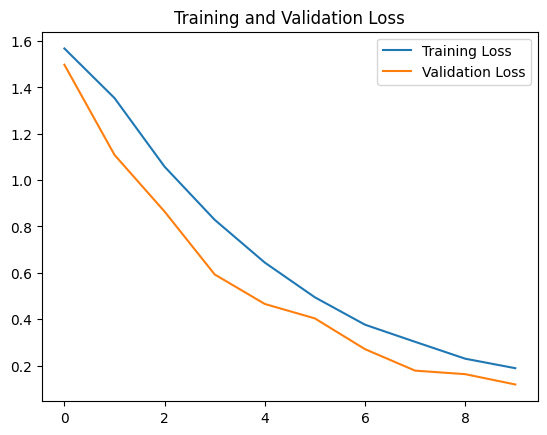

In [43]:
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")
plt.show()

In [50]:
model.save("movie_reviews.h5")

In [ ]:
model = tf.keras.models.load_model("movie_reviews.h5")

In [58]:
sample_text = vectoriser("Subpar writing and bad scenes, this movie can certainly be improved")

In [61]:
result = model.predict(np.expand_dims(sample_text, 0))
result

1/1 [==============================] - 0s 161ms/step


array([[0.4369805 , 0.19562429, 0.3440781 , 0.01050794, 0.01280913]],
      dtype=float32)

In [63]:
train.columns[3:]

Index(['Sentiment'], dtype='object')

In [64]:
def score_comment(comment):
    vectorised_comment = vectoriser([comment])
    result = model.predict(vectorised_comment)
    
    text = ''
    for idx, col in enumerate(train.columns[3:]):
        text += "{}: {}\n".format(col, result[0][idx] > 0.5)
        
    return text

In [ ]:
s

In [ ]:
interface = gr.Interface(
    score_comment,
    gr.Textbox(lines = 3, placeholder = "Movie Review"),
    "text"
)

In [ ]:
interface.launch(share = True)

In [ ]:
# Try find code on how to run prediction on array of comments